# Dataset

The dataset used in this analysis consists of beer reviews from two beer rating websites,**BeerAdvocate** and **RateBeer**, for a period ranging from 2001 to 2017. For each website, we have 5 files:
- users.csv: metadata about reviewers
- beers.csv : metadata about reviewed beers
- breweries.csv : metadata about breweries
- ratings.txt : all reviews given by users, including numerical ratings and sometimes textual reviews
- reviews.txt : only reviews given by users that include both numerical ratings and textual reviews

In our analysis, we will not use textual reviews. Thus, we will only use ratings.txt files and not reviews.txt files, as we will use all reviews, whether or not they include textual reviews.

### Load data into Dataframes

The .csv files are not too large and can efficiently be loaded into DataFrames.

In [3]:
BA_DATA_FOLDER = 'data/BeerAdvocate/'
RB_DATA_FOLDER = 'data/RateBeer/'

BA_USERS = BA_DATA_FOLDER+"users.csv"
BA_BEERS = BA_DATA_FOLDER+"beers.csv"
BA_BREWERIES = BA_DATA_FOLDER+"breweries.csv"

RB_USERS = RB_DATA_FOLDER+"users.csv"
RB_BEERS = RB_DATA_FOLDER+"beers.csv"
RB_BREWERIES = RB_DATA_FOLDER+"breweries.csv"

In [4]:
ba_users = pd.read_csv(BA_USERS)
ba_beers = pd.read_csv(BA_BEERS)
ba_breweries = pd.read_csv(BA_BREWERIES)

rb_users = pd.read_csv(RB_USERS)
rb_beers = pd.read_csv(RB_BEERS)
rb_breweries = pd.read_csv(RB_BREWERIES)

On the other hand, the ratings.txt files are extremely large, and trying to load them directly into DataFrames leads to kernel freezes. In order to circumvent this problem, we wrote a script (review_parser.py, located in src/scripts), which processes each rating file by dividing it into parts, parsing each part, and saving as JSON. In the notebook, we then load the different JSON files into DataFrames, that we concatenate. Dividing the large .txt files into smaller JSON chunks and then loading each chunk separately, avoids trying to load the entire file into memory at once, which can cause kernel freezes due to memory overload. In addition, JSON is a format that pandas can read efficiently.

In [5]:
# Load BeerAdvocate ratings stored in json files into a single DataFrame
ba_json_files = glob.glob(BA_DATA_FOLDER+'*.json')
ba_df_list = [pd.read_json(file) for file in ba_json_files]
ba_ratings = pd.concat(ba_df_list, ignore_index=True)

In [6]:
# Load RateBeer ratings stored in json files into a single DataFrame
rb_json_files = glob.glob(RB_DATA_FOLDER+'*.json')
rb_df_list = [pd.read_json(file) for file in rb_json_files]
rb_ratings = pd.concat(rb_df_list, ignore_index=True)

### First look at the data

We will now examine the different DataFrames in more detail.

**BeerAdvocate beer Dataframe**

In [7]:
ba_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
156895,9802,60 Shilling Ale,1042,Nodding Head Brewery,Scottish Ale,40,19,3.29,80.0,NaN,4.75,3.283750,NaN,0,NaN
104845,171163,Narquois Rouge,4980,Engine House No. 9,Flanders Red Ale,2,1,3.73,NaN,NaN,7.80,3.710000,-0.491621,1,3.75
132422,225840,Saison Delivery,18120,Trinity Brewing Company,Saison / Farmhouse Ale,13,2,4.41,87.0,NaN,NaN,4.200769,NaN,0,NaN
161473,92659,Port Barrel Aged Dark Lord Imperial Stout,26,3 Floyds Brewing Co.,Russian Imperial Stout,116,10,4.20,91.0,NaN,15.00,4.268017,NaN,0,NaN


Let us explain the different columns of the BeerAdvocate beer Dataframe, in which each row is a beer:
- beer_id, beer_name, brewery_id, brewery_name, style are explicit
- nbr_ratings: total number of reviews for that beer, whether or not they include textual reviews
- nbr_reviews: number of reviews for that beer that include textual reviews
- avg: average rating (out of 5) given to the beer based on user ratings
- ba_score: the BeerAdvocate score assigned to the beer, which corresponds to the beer's overall rating within its style category, calculated using a trimmed mean and a custom Bayesian formula that adjusts for the beer's style, balancing the score based on the number of ratings and the style's average
- bros_score: beer rating given by the site’s founders
- abv: 'Alcohol by volume', which indicates the percentage of alcohol content in the beer
- avg_computed: average rating (out of 5) recalculated using a weighted sum of the different aspect ratings
- zscore: z-score of the beer's average rating, which is a statistical measure that indicates how many standard deviations the average rating is from the mean of all ratings from the BeerAdvocate dataset
- nbr_matched_valid_ratings: number of valid ratings for beers that were successfully matched between two BeerAdvocate and RateBeer
- avg_matched_valid_ratings: average rating of those matched and valid ratings across the sites

The last two columns are related to the analysis performed by Robert West and Gael Lederrey in the following paper: https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf.

**RateBeer beer Dataframe**

In [8]:
rb_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
196026,423313,Populuxe 3rd Anniversary IPA,16245,Populuxe Brewing Company,India Pale Ale (IPA),1,NaN,NaN,3.09,6.8,3.70,NaN,0,NaN
179681,264259,Peter Bs DIPA,2128,Peter Bs Brewpub,Imperial IPA,2,NaN,NaN,3.23,9.5,3.80,NaN,0,NaN
325169,76468,Maumee Bay Naked Saison,1507,Maumee Bay Brewing Co.,Saison,2,NaN,NaN,2.70,NaN,2.65,NaN,0,NaN
129583,342459,Äppelbo Imperial Nitro Stout,20270,Äppelbo Bryggeri,Imperial Stout,14,24.0,0.0,2.83,9.5,2.80,-1.242101,14,2.8


Let us explain the different columns of the RateBeer beer Dataframe, in which each row is a beer:

The beer_id, beer_name, brewery_id, brewery_name, style, nbr_ratings, avg, abv, avg_computed, z-score, nbr_matched_valid_ratings and avg_matched_valid_ratings are the same as for the BeerAdvocate beer Dataframe.

Some columns are missing compared to the BeerAdvocate beer Dataframe: ba_score and bros_score (which makes sense as these are BeerAdvocate-specific scores), and nbr_reviews.

New columns are present compared to the BeerAdvocate beer Dataframe:
- overall_score: score (out of 100) which "reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer", calculated by considering the ratings given by each user and the total number of ratings for the beer
- style_score: score given to the beer (out of 100) specifically within its style category

**Characteristics of the beer data**

Let us determine how many different beers are present in the dataset.

In [9]:
print('Number of different beers reviewed in Beer Advocate:', ba_beers.shape[0])
print('Number of different beers reviewed in Rate Beer:', rb_beers.shape[0])
print('Number of different beers reviewed in the combined datasets:', pd.concat([ba_beers['beer_id'], rb_beers['beer_id']]).nunique())

Number of different beers reviewed in Beer Advocate: 280823
Number of different beers reviewed in Rate Beer: 442081
Number of different beers reviewed in the combined datasets: 502784


Let us determine how many different beer styles are present in the dataset.

In [10]:
print('Number of different beer styles reviewed in Beer Advocate:', ba_beers['style'].nunique())
print('Number of different beer styles reviewed in Rate Beer:', rb_beers['style'].nunique())
print('Number of different beer styles reviewed in the combined datasets:', pd.concat([ba_beers['style'], rb_beers['style']]).nunique())

Number of different beer styles reviewed in Beer Advocate: 104
Number of different beer styles reviewed in Rate Beer: 94
Number of different beer styles reviewed in the combined datasets: 184


**BeerAdvocate user Dataframe**

In [11]:
ba_users.sample(4)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
41538,2,0,veroymatt.713731,veroymatt,1.358507e+09,NaN
11806,316,1,jeltmaaj.672497,JeltMaaj,1.334311e+09,"United States, Illinois"
46252,1,1,witweizenlover.627758,WitWeizenLover,1.318586e+09,"United States, Illinois"
107137,2,0,posty10.780830,POSTY10,1.391857e+09,"United States, Delaware"


Let us explain the different columns of the BeerAdvocate user Dataframe, in which each row is a reviewer:
- nbr_ratings, nbr_reviews, user_id, user_name, and location are explicit
- joined: timestamp indicating when the user joined BeerAdvocate in Unix timestamp format (the number of seconds since January 1, 1970, 00:00:00 UTC)

**RateBeer user Dataframe**

In [12]:
rb_users.sample(4)

,nbr_ratings,user_id,user_name,joined,location
44780,1,92557,IronLionZion,1.245838e+09,NaN
46292,2,426793,bluegrass,1.473070e+09,"United States, California"
60682,1,264552,NWBEERGUY,1.371377e+09,NaN
13175,45,119838,karlsnes,1.293448e+09,Norway


Let us explain the different columns of the RateBeer user Dataframe, in which each row is a reviewer:

The columns are the same as in the BeerAdvocate user Dataframe (joined is obviously the timestamp indicating when the user joined RateBeer and not BeerAdvocate), except that nbr_reviews is missing.

**Number of users in the dataset**

In [13]:
print('Number of users from Beer Advocate:', ba_users.shape[0])
print('Number of users from Rate Beer:', rb_users.shape[0])
print('Total number of users:', (ba_users.shape[0] + rb_users.shape[0]))

Number of users from Beer Advocate: 153704
Number of users from Rate Beer: 70174
Total number of users: 223878


**Brewery Dataframes**

In [14]:
ba_breweries.sample(4)

,id,location,name,nbr_beers
2324,661,Canada,Muskoka Brewery,81
902,6985,England,Vale Brewery Company,14
6870,2425,Czech Republic,Pivovar Zlatopramen,6
8897,1018,"United States, California",San Pedro Brewing Company,19


In [15]:
rb_breweries.sample(4)

,id,location,name,nbr_beers
5953,5262,Germany,Weldebräu,34
1070,13241,Canada,Glutenberg Brewing Company,42
14664,4070,"United States, Washington",The Rock Wood Fired Pizza & Brewery,18
6586,6597,Switzerland,Wetzel,5


The columns are explicit and are the same for the 2 websites. Each row is a brewery.

**Rating Dataframes**

In [16]:
ba_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
2196993,Claritas,65003.0,Mike Hess Brewing - Miramar,23347.0,Kölsch,5.25,2016-12-05 11:00:00,ChuckTom,chucktom.1101100,4.5,4.25,4.5,4.5,4.5,4.44
2055065,"The Kimmie, The Yink & The Holy Gose",99790.0,Anderson Valley Brewing Company,193.0,Gose,4.20,2015-08-04 10:00:00,beermike83,beermike83.1023229,4.0,4.00,5.0,4.0,4.5,4.20
2690065,Sour In The Rye,51741.0,The Bruery,16866.0,American Wild Ale,7.80,2013-10-12 10:00:00,rc51sport,rc51sport.720425,NaN,NaN,NaN,NaN,NaN,4.00
2258751,Grapefruit Sculpin,89174.0,Ballast Point Brewing Company,199.0,American IPA,7.00,2015-03-10 11:00:00,avisong,avisong.609807,4.5,4.50,4.5,4.5,4.5,4.50


In [17]:
rb_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
2254016,CAP Exciter IPA,216768.0,CAP Brewery,16529.0,India Pale Ale (IPA),6.0,2013-08-08 10:00:00,gyllenbock,90466.0,3.0,7.0,3.0,6.0,12.0,3.1
5157313,BridgePort IPA,106.0,BridgePort Brewing,21.0,India Pale Ale (IPA),5.5,2005-07-24 10:00:00,Malakin,10451.0,3.0,6.0,4.0,7.0,14.0,3.4
6658027,Lindemans Kriek,344.0,Brouwerij Lindemans,62.0,Lambic Style - Fruit,3.5,2005-05-10 10:00:00,madsberg,5011.0,4.0,7.0,3.0,8.0,14.0,3.6
1364317,Jäcklein Jubiläums Bier,88356.0,Bürgerliches Brauhaus Saalfeld,659.0,Oktoberfest/Märzen,5.6,2009-10-24 10:00:00,KimJohansen,38332.0,3.0,5.0,3.0,6.0,12.0,2.9


The columns are the same for the 2 Dataframes. Each row corresponds to an individual review. Most column names are explicit. 
- 'appearance','aroma', 'palate','taste' correspond to aspect ratings (out of 5)
- 'overall' is the mean of the 4 aspect ratings
- 'rating' is the final rating given by the user to the beer

**Number of reviews in the dataset**

In [18]:
print('Number of reviews from Beer Advocate:', ba_ratings.shape[0])
print('Number of reviews from Rate Beer:', rb_ratings.shape[0])
print('Total number of reviews:', (ba_ratings.shape[0] + rb_ratings.shape[0]))

Number of reviews from Beer Advocate: 8393034
Number of reviews from Rate Beer: 7122076
Total number of reviews: 15515110


# 0) Data cleaning

### **BASIC CLEANING**

## Filtering Dataframes

Let us start by removing columns in the different Dataframes that we will not use in our analysis.

The following rows will not be used in our analysis:
nbr_reviews, ba_score, bros_score, abv, avg_computed, zscore, nbr_matched_valid_ratings and avg_matched_valid_ratings, overall_score and style_score.

Let us remove them.

In [19]:
useless_columns_ba = ['nbr_reviews', 'ba_score', 'bros_score', 'abv', 'avg_computed', 'zscore', 'nbr_matched_valid_ratings', 'avg_matched_valid_ratings']
ba_beers = ba_beers.drop(columns=useless_columns_ba)
print(ba_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


In [20]:
useless_columns_rb = [col for col in useless_columns_ba if col not in ['nbr_reviews','ba_score', 'bros_score']] + ['overall_score', 'style_score']
rb_beers = rb_beers.drop(columns=useless_columns_rb)
print(rb_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


We will also not use the timestamps indicating the time when users joined the platforms, so let us remove this as well.

In [21]:
ba_users = ba_users.drop(columns='joined')
rb_users = rb_users.drop(columns='joined')
print(ba_users.columns)

Index(['nbr_ratings', 'nbr_reviews', 'user_id', 'user_name', 'location'], dtype='object')


## Verifying value types

Let us verify that the values in the different columns of the different Dataframes have the appropriate type.

In [22]:
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [23]:
print(ba_users.dtypes,'\n','\n',rb_users.dtypes)

nbr_ratings     int64
nbr_reviews     int64
user_id        object
user_name      object
location       object
dtype: object 
 
 nbr_ratings     int64
user_id         int64
user_name      object
location       object
dtype: object


In [24]:
print(ba_breweries.dtypes,'\n','\n',rb_breweries.dtypes)

id            int64
location     object
name         object
nbr_beers     int64
dtype: object 
 
 id            int64
location     object
name         object
nbr_beers     int64
dtype: object


In [25]:
print(ba_ratings.dtypes,'\n','\n',rb_ratings.dtypes)

beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                 object
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object 
 
 beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                float64
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object


The types of the values in the different columns of the different Dataframes seem appropriate.

## Dealing with missing values

*Beers with no reviews*

Let us verify that all the beers in the beer DataFrames have at least received 1 review.

In [26]:
# get the number of beers with 0 reviews
# Beer Advocate
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)

# Rate Beer
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 32841
Number of beers with no reviews (Rate Beer): 45391


We can see that in Both Dataframes, there are many beers with no reviews. These beers are useless for our analysis and we can remove them from the DataFrames.

In [27]:
# remove beers with zero reviews
# Beer Advocate
ba_beers = ba_beers[ba_beers['nbr_ratings'] != 0]
# Rate Beer
rb_beers = rb_beers[rb_beers['nbr_ratings'] != 0]

# verification:
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 0
Number of beers with no reviews (Rate Beer): 0


*Reviews with no final rating*

Let us now determine if some reviews lack a final rating. If that is the case, we will remove them from the rating DataFrames as we will need final ratings in our analysis. The final rating, unlike the overall rating, cannot be calculated using aspect ratings, so we cannot retrieve missing final rating values. Some reviews may lack certain aspect ratings, but we will not remove them as if they do have a final rating, we will be able to use them in many parts of our analysis.

In [28]:
# get the number of reviews with Nan in the 'rating' column
# Beer Advocate
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
# Rate Beer
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 2
Number of reviews lacking a final rating (Rate Beer): 2


There are only 2 reviews lacking a final rating for each website, but let us remove them anyway.

In [29]:
# remove reviews with no final rating
ba_ratings = ba_ratings.dropna(subset=['rating'])
rb_ratings = rb_ratings.dropna(subset=['rating'])

# verification 
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 0
Number of reviews lacking a final rating (Rate Beer): 0


## Cleaning location information

Let us have a closer look at the values present in the 'location' column of user and brewery DataFrames.

In [30]:
ba_users['location'].value_counts()

location
United States, California       11638
United States, Pennsylvania      8689
United States, New York          7432
United States, Illinois          6866
United States, Massachusetts     6658
                                ...  
Angola                              1
Kazakhstan                          1
Tokelau                             1
Sri Lanka                           1
Sint Maarten                        1
Name: count, Length: 194, dtype: int64

In [31]:
rb_users['location'].value_counts()

location
Canada                         3255
United States, California      2804
England                        2734
Poland                         1701
United States, Pennsylvania    1632
                               ... 
Liechtenstein                     1
Lesotho                           1
East Timor                        1
Falkland Islands                  1
Tibet                             1
Name: count, Length: 222, dtype: int64

In [32]:
ba_breweries['location'].value_counts()

location
Germany                                                                                                                                                                          1431
England                                                                                                                                                                           997
United States, California                                                                                                                                                         929
Canada                                                                                                                                                                            775
United States, Washington                                                                                                                                                         411
                                                                                 

In [33]:
rb_breweries['location'].value_counts()

location
England                      2124
Germany                      1999
Italy                        1051
Canada                        884
United States, California     867
                             ... 
Senegal                         1
Mozambique                      1
French Polynesia                1
Papua New Guinea                1
Gabon                           1
Name: count, Length: 267, dtype: int64

In [34]:
# see all the possibilities for locations containing 'Wales', 'Scotland', 'England' or 'Ireland'
ba_breweries[ba_breweries['location'].str.contains('Wales|Scotland|England|Ireland', case=False, na=False)]['location'].value_counts()

location
England                     997
Scotland                    104
Ireland                      84
Wales                        58
United Kingdom, England      32
Northern Ireland             25
United Kingdom, Scotland      3
United Kingdom, Wales         2
Name: count, dtype: int64

In [35]:
# see all the possibilities for locations starting with 'Canada'
ba_breweries[ba_breweries['location'].str.startswith('Canada', na=False)]['location'].value_counts()

location
Canada                               775
Canada, Quebec                        28
Canada, Ontario                       25
Canada, British Columbia              12
Canada, Nova Scotia                    6
Canada, Alberta                        6
Canada, Manitoba                       3
Canada, Saskatchewan                   2
Canada, New Brunswick                  2
Canada, Newfoundland and Labrador      1
Name: count, dtype: int64

We can make 4 important observations: 
- US locations all contain state information
- some locations contain embedded HTML links
- Canada locations contain province information
- UK countries are represented in 2 different ways: either 'United Kingdom, *country*' or '*country*'

We will remove both these HTML links and the state and province information, as we will not use it in our analysis. We will also make sure that UK countries are represented in only 1 way. We will do so by applying a function named 'clean_location_column' which cleans the location information and that we have written in src/utils/data_utils.py().

In [36]:
# Clean location information in user and brewery dataframes
# Beer Advocate
ba_users = clean_location_column(ba_users)
ba_breweries = clean_location_column(ba_breweries)

# Rate Beer
rb_users = clean_location_column(rb_users)
rb_breweries = clean_location_column(rb_breweries)

Let us now have a look at the cleaned location columns.

In [37]:
ba_users['location'].value_counts()

location
United States                               113223
nan                                          31279
Canada                                        3324
England                                        791
Australia                                      520
                                             ...  
South Georgia and South Sandwich Islands         1
Angola                                           1
Kazakhstan                                       1
Egypt                                            1
Sint Maarten                                     1
Name: count, Length: 146, dtype: int64

In [38]:
rb_users['location'].value_counts()

location
United States       26855
nan                 19582
Canada               3255
England              2734
Poland               1701
                    ...  
Honduras                1
Falkland Islands        1
Kyrgyzstan              1
Papua New Guinea        1
Tibet                   1
Name: count, Length: 174, dtype: int64

In [39]:
ba_breweries['location'].value_counts()

location
United States               7399
Germany                     1431
England                     1029
Canada                       860
France                       402
                            ... 
Dominica                       1
French Guiana                  1
Senegal                        1
Gibraltar                      1
Virgin Islands (British)       1
Name: count, Length: 200, dtype: int64

In [40]:
rb_breweries['location'].value_counts()

location
United States            6921
England                  2124
Germany                  1999
Italy                    1051
Canada                    884
                         ... 
Sao Tome and Principe       1
Iraq                        1
Micronesia                  1
French Guiana               1
Gabon                       1
Name: count, Length: 217, dtype: int64

In [41]:
# see all the possibilities for locations containing 'Wales', 'Scotland', 'England' or 'Ireland'
ba_breweries[ba_breweries['location'].str.contains('Wales|Scotland|England|Ireland', case=False, na=False)]['location'].value_counts()

location
England             1029
Scotland             107
Ireland               84
Wales                 60
Northern Ireland      25
Name: count, dtype: int64

In [42]:
# see all the possibilities for locations starting with 'Canada'
ba_breweries[ba_breweries['location'].str.startswith('Canada', na=False)]['location'].value_counts()

location
Canada    860
Name: count, dtype: int64

Now that the location information has been cleaned, we can look a the distribution of the location of both users and breweries in the dataset.

Let us start by observing the distribution of user locations.

In [43]:
print('Number of distinct user locations:',pd.concat([ba_users['location'],rb_users['location']]).nunique())

Number of distinct user locations: 202


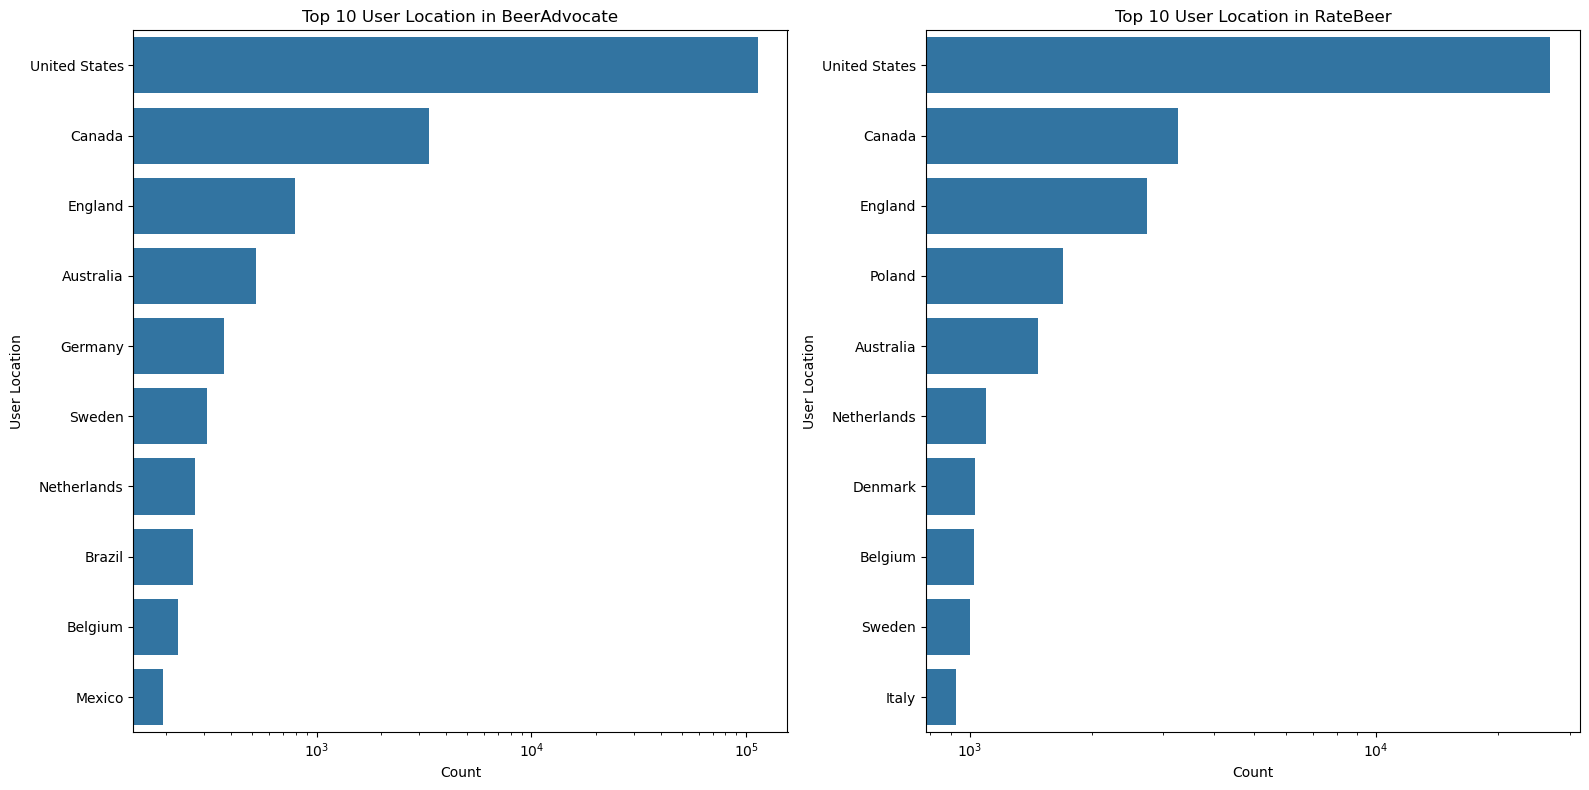

In [44]:
# Distribution of user locations
# 10 most frequent user locations for each dataset (to make plots easier to read)
ba_top_10_user_locations = ba_users[ba_users['location'] != 'nan']['location'].value_counts().head(10)
rb_top_10_user_locations = rb_users[rb_users['location'] != 'nan']['location'].value_counts().head(10)

top_10_plots(ba_top_10_user_locations,rb_top_10_user_locations,'User Location') # Plot function

We can see that for the 2 websites, the vast majority of users come from the US. The next most common user locations are Canada and England.

Let us now observe the distribution of brewery locations.

In [45]:
print('Number of distinct brewery locations:',pd.concat([ba_breweries['location'],rb_breweries['location']]).nunique())

Number of distinct brewery locations: 218


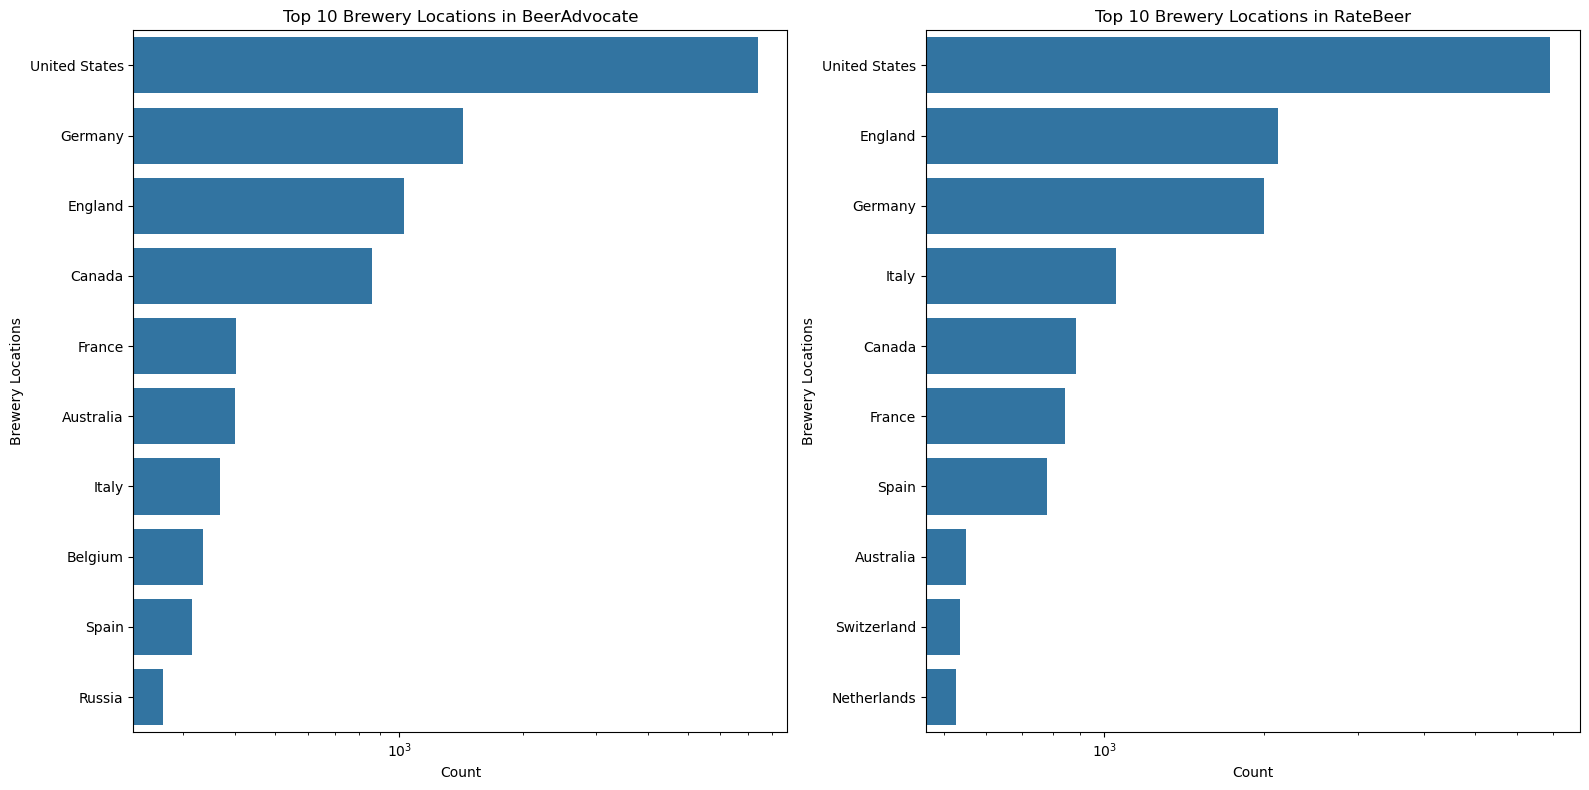

In [46]:
# Distribution of brewery locations
# 10 most frequent brewery locations for each dataset (to make plots easier to read)
ba_top_10_brewery_locations = ba_breweries[ba_breweries['location'] != 'nan']['location'].value_counts().head(10)
rb_top_10_brewery_locations = rb_breweries[rb_breweries['location'] != 'nan']['location'].value_counts().head(10)

top_10_plots(ba_top_10_brewery_locations,rb_top_10_brewery_locations,'Brewery Locations')

Similarly, we can observe that the vast majority of breweries included in the 2 datasets are located in the US. The next most common brewery locations are Germany and England.

### **ADDITION OF USEFUL COLUMNS**

To streamline our analysis and avoid redundant computations, we will calculate certain statistics that will be used in several parts of the analysis once and store them as new columns in the respective dataframes.

Let us first add a column to the rating dataframes corresponding to the average rating given by the user who wrote the review.

In [47]:
# calculate the average rating for each user
average_ratings_by_user_ba = ba_ratings.groupby('user_id')['rating'].mean().reset_index()
average_ratings_by_user_ba.rename(columns={'rating': 'user_avg_rating'}, inplace=True)

average_ratings_by_user_rb = rb_ratings.groupby('user_id')['rating'].mean().reset_index()
average_ratings_by_user_rb.rename(columns={'rating': 'user_avg_rating'}, inplace=True)

# add the average ratings by user to the rating dataframes
ba_ratings = ba_ratings.merge(average_ratings_by_user_ba, on='user_id', how='left')
rb_ratings = rb_ratings.merge(average_ratings_by_user_rb, on='user_id', how='left')

ba_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_avg_rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,3.730887
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,3.885664
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,3.866884
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,3.563226
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,3.624354


Let us now add a column to the rating dataframes corresponding to the average rating of all beers coming from the brewery that produced the reviewed beer. This metric can be used as a proxy for brewery reputation and will be used in certain parts of the analysis to account for the fact that some breweries might have established reputations that bias user ratings.

In [48]:
# calculate the average rating for each brewery
average_ratings_by_brewery_ba = ba_ratings.groupby('brewery_id')['rating'].mean().reset_index()
average_ratings_by_brewery_ba.rename(columns={'rating': 'brewery_avg_rating'}, inplace=True)

average_ratings_by_brewery_rb = rb_ratings.groupby('brewery_id')['rating'].mean().reset_index()
average_ratings_by_brewery_rb.rename(columns={'rating': 'brewery_avg_rating'}, inplace=True)

# add the average ratings by brewery to the rating dataframes
ba_ratings = ba_ratings.merge(average_ratings_by_brewery_ba, on='brewery_id', how='left')
rb_ratings = rb_ratings.merge(average_ratings_by_brewery_rb, on='brewery_id', how='left')

ba_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_avg_rating,brewery_avg_rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,3.730887,2.880000
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,3.885664,3.526513
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,3.866884,3.526513
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,3.563226,3.526513
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,3.624354,3.526513


We will now add a column to the rating dataframes corresponding to the average rating of all beers with the same style as the reviewed beer. 

In [49]:
# calculate the average rating for each beer style
average_ratings_by_style_ba = ba_ratings.groupby('style')['rating'].mean().reset_index()
average_ratings_by_style_ba.rename(columns={'rating': 'style_avg_rating'}, inplace=True)

average_ratings_by_style_rb = rb_ratings.groupby('style')['rating'].mean().reset_index()
average_ratings_by_style_rb.rename(columns={'rating': 'style_avg_rating'}, inplace=True)

# add the average ratings by style to the rating dataframes
ba_ratings = ba_ratings.merge(average_ratings_by_style_ba, on='style', how='left')
rb_ratings = rb_ratings.merge(average_ratings_by_style_rb, on='style', how='left')

ba_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_avg_rating,brewery_avg_rating,style_avg_rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,3.730887,2.880000,2.986608
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,3.885664,3.526513,3.542445
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,3.866884,3.526513,3.542445
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,3.563226,3.526513,3.542445
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,3.624354,3.526513,3.542445


Finally, we will add a column to the rating dataframes corresponding to the number of reviews given by the user who wrote the review.

In [50]:
# merge the rating dataframes with the users dataframes on user_id
ba_ratings = ba_ratings.merge(ba_users[['user_id', 'nbr_reviews']], on='user_id', how='left')
rb_ratings = rb_ratings.merge(rb_users[['user_id', 'nbr_ratings']], on='user_id', how='left')

ba_ratings = ba_ratings.rename(columns={'nbr_reviews': 'user_nb_reviews'})
rb_ratings = rb_ratings.rename(columns={'nbr_ratings': 'user_nb_reviews'})

ba_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_avg_rating,brewery_avg_rating,style_avg_rating,user_nb_reviews
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,3.730887,2.880000,2.986608,465.0
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,3.885664,3.526513,3.542445,2504.0
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,3.866884,3.526513,3.542445,1143.0
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,3.563226,3.526513,3.542445,31.0
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,3.624354,3.526513,3.542445,604.0


### **'LOCATION-SPECIFIC' CLEANING**

Several parts of our analysis will involve comparing data from different countries and will require working with the location information in the user DataFrames. In these parts, we will only consider countries with a 'sufficiently large' number of reviewers, as only a few reviewers may not be representative of an entire country. We will thus filter out countries that we consider to have not enough reviewers. We decide arbitrarily to filter out countries with less than 50 different reviewers.

In this part of the data cleaning, we will work on a copy of the original DataFrames, and we will use these copies only for the parts of the analysis where we compare certain countries. Indeed, this filtering is not relevant for the parts that do not involve comparing certain countries.

In [51]:
# create copies of the user and rating DataFrames, which will undergo filtering related to the location information
ba_users_loc_filtered = ba_users.copy()
rb_users_loc_filtered = rb_users.copy()
ba_ratings_loc_filtered = ba_ratings.copy()
rb_ratings_loc_filtered = rb_ratings.copy()

## Removing users with missing location information

First, let us determine if some users are missing the location information.

In [52]:
# get the number of users with 'nan' in the 'location' column
# Beer Advocate
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
# Rate Beer
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 31279
Number of users lacking the location information (Rate Beer): 19582


We can see that there are indeed some users missing the location information. Let us remove these users.

In [53]:
# remove users with 'nan' in the 'location' column
ba_users_loc_filtered = ba_users_loc_filtered[ba_users_loc_filtered['location'] != 'nan']
rb_users_loc_filtered = rb_users_loc_filtered[rb_users_loc_filtered['location'] != 'nan']

# verification
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 0
Number of users lacking the location information (Rate Beer): 0


## Filtering out users and reviews written by users from countries with too few users

Let us first identify the countries with a number of users that is smaller than the threshold we set earlier, that is, 10 users.

In [54]:
USER_NB_THRESHOLD = 50

# concatenate the 'location' columns from the 2 user dataframes
combined_locations = pd.concat([ba_users_loc_filtered['location'], rb_users_loc_filtered['location']])

# get the counts of each unique value in 'location'
location_counts = combined_locations.value_counts()

# keep only locations with less than 50 counts
locations_with_few_counts = location_counts[location_counts < USER_NB_THRESHOLD]

# Get the list of location values with less than 50 counts
countries_with_few_users = locations_with_few_counts.index.tolist()

print("Countries with less than 50 users across both DataFrames:")
print(countries_with_few_users)

Countries with less than 50 users across both DataFrames:
['Aotearoa', 'Panama', 'Colombia', 'Bosnia and Herzegovina', 'Costa Rica', 'Cyprus', 'Luxembourg', 'Belarus', 'Dominican Republic', 'El Salvador', 'Peru', 'Moldova', 'Guatemala', 'Ecuador', 'Macedonia', 'Venezuela', 'Paraguay', 'Uruguay', 'Lebanon', 'Malaysia', 'Vietnam', 'Indonesia', 'Virgin Islands (U.S.)', 'Bahamas', 'Faroe Islands', 'Afghanistan', 'Malta', 'Andorra', 'Cambodia', 'Guam', 'Kenya', 'United Arab Emirates', 'Isle of Man', 'Antarctica', 'Cayman Islands', 'Bermuda', 'Bolivia', 'Honduras', 'Montenegro', 'Egypt', 'Tanzania', 'Uganda', 'Botswana', 'Zimbabwe', 'Albania', 'Tajikistan', 'Azerbaijan', 'Trinidad and Tobago', 'American Samoa', 'Tunisia', 'Jersey', 'Vanuatu', 'Pakistan', 'Jordan', 'Mauritius', 'Belize', 'Nicaragua', 'Barbados', 'Mozambique', 'Aruba', 'Uzbekistan', 'Nigeria', 'Palestine', 'Namibia', 'Abkhazia', 'Papua New Guinea', 'Armenia', 'Morocco', 'Nepal', 'Burkina Faso', 'Marshall Islands', 'Ascension I

Let us determine if filtering out these 113 countries would leave us with enough data, ie with enough countries, to perform our analysis comparing different countries.

In [55]:
print('Remaining countries after filtering:',(len(location_counts)-len(locations_with_few_counts)))

Remaining countries after filtering: 55


Filtering out those countries would leave us with 55 countries, which is enough to perform our analysis.

Ultimately, we would like to remove reviews from users coming from countries with too few reviewers. 
To do so, we will start by adding the user location information to review DataFrames. This will facilitate the filtering and analysis.

In [56]:
# merge rating dataframes with user dataframes on 'user_id' to add the'location' column to rating dataframes as 'user_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'user_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'user_location'})

ba_ratings_loc_filtered.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_avg_rating,brewery_avg_rating,style_avg_rating,user_nb_reviews,user_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,3.730887,2.880000,2.986608,465.0,United States
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,3.885664,3.526513,3.542445,2504.0,United States
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,3.866884,3.526513,3.542445,1143.0,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,3.563226,3.526513,3.542445,31.0,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,3.624354,3.526513,3.542445,604.0,Northern Ireland


We now must remove the reviews from users whose location is NaN. Such users correspond to the users lacking a ocation information that have been previously removed from the user dataframes, but which are still present in the review dataframes.

In [57]:
# remove reviews from users for which the location is NaN
ba_ratings_loc_filtered = ba_ratings_loc_filtered.dropna(subset=['user_location'])
rb_ratings_loc_filtered = rb_ratings_loc_filtered.dropna(subset=['user_location'])

We can now remove reviews from users coming from countries with too few reviewers.

In [58]:
# remove reviews where 'user_location' is in the 'countries_with_few_users' list
ba_ratings_loc_filtered = ba_ratings_loc_filtered[~ba_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]
rb_ratings_loc_filtered = rb_ratings_loc_filtered[~rb_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]

We will now remove users coming from countries with too few reviewers from the user dataframes.

In [59]:
# remove users for which 'location' is in the 'countries_with_few_users' list
ba_users_loc_filtered = ba_users_loc_filtered[~ba_users_loc_filtered['location'].isin(countries_with_few_users)]
rb_users_loc_filtered = rb_users_loc_filtered[~rb_users_loc_filtered['location'].isin(countries_with_few_users)]

In [60]:
ba_users_loc_filtered.head()

,nbr_ratings,nbr_reviews,user_id,user_name,location
0,7820,465,nmann08.184925,nmann08,United States
1,2521,2504,stjamesgate.163714,StJamesGate,United States
2,1797,1143,mdagnew.19527,mdagnew,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,Northern Ireland


In [61]:
rb_users_loc_filtered.head()

,nbr_ratings,user_id,user_name,location
0,1890,175852,Manslow,Poland
1,89,442761,MAGICuenca91,Spain
2,169,288889,Sibarh,Poland
3,3371,250510,fombe89,Spain
4,13043,122778,kevnic2008,Germany


## Adding brewery location information to filtered review DataFrames

Finally, to facilitate our analysis, we will add the brewery location information for each beer reviewed in the review dataframes. 

In [62]:
ba_breweries_loc_filtered = ba_breweries.copy()
rb_breweries_loc_filtered = rb_breweries.copy()

In [63]:
# rename 'id' column to 'brewerie_id' column in brewery dataframes to facilitate merging with rating dataframes
ba_breweries_loc_filtered = ba_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})
rb_breweries_loc_filtered = rb_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})

# merge rating dataframes with brewery dataframes on 'brewery_id' to add the'location' column to rating dataframes as 'brewerie_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

ba_ratings_loc_filtered.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,user_avg_rating,brewery_avg_rating,style_avg_rating,user_nb_reviews,user_location,brewery_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,...,3.25,2.75,3.0,2.88,3.730887,2.880000,2.986608,465.0,United States,Gabon
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,...,3.50,4.00,3.5,3.67,3.885664,3.526513,3.542445,2504.0,United States,Northern Ireland
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,...,3.50,4.00,3.5,3.73,3.866884,3.526513,3.542445,1143.0,Northern Ireland,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,...,4.00,4.00,4.5,3.98,3.563226,3.526513,3.542445,31.0,Northern Ireland,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,...,4.00,4.00,4.0,4.00,3.624354,3.526513,3.542445,604.0,Northern Ireland,Northern Ireland
